In [1]:
import gym_2048
import gym
import numpy as np
import tensorflow as tf

env=gym.make('2048-v0')
obs=env.reset()
print(obs)
print(env.observation_space)
print(env.action_space)
obs,reward,done,info=env.step(0)
print(obs)

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 2 0 2]]
Box(2, 4294967296, (4, 4), int64)
Discrete(4)
[[0 0 0 0]
 [0 0 0 0]
 [0 2 0 0]
 [4 0 0 0]]


/usr/local/lib/python3.6/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


In [2]:
#Random Agent 
score=0
step=0
obs=env.reset()
while True:
    action=env.action_space.sample()
    obs,reward,done,info=env.step(action)
    score+=reward
    step+=1
    if done:
        break
    
print(f'score>{score}\tsteps>{step}')
print(obs)

score>788	steps>99
[[ 8  2  8  2]
 [64 16  2  8]
 [ 4 64  8  4]
 [ 2  8 16  2]]


In [3]:
layer_count=12 # 0,2,4,8,16,32,64,128,256,512,1024,2048
table={2**i:i for i in range(layer_count)}
print(table)

def preprocess(obs):
    x=np.zeros((4,4,layer_count))
    for i in range(4):
        for j in range(4):
            if obs[i,j]>0:
                v=min(obs[i,j], 2**(layer_count-1))
                x[i,j,table[v]]=1
            else:
                x[i,j,0]=1
    return x

{1: 0, 2: 1, 4: 2, 8: 3, 16: 4, 32: 5, 64: 6, 128: 7, 256: 8, 512: 9, 1024: 10, 2048: 11}


In [4]:
def build_model():
    dense1=128
    dense2=128
    x=tf.keras.Input(shape=(4,4,layer_count))
    conv_a=tf.keras.layers.Conv2D(dense1,kernel_size=(2,1),activation='relu')(x)
    conv_b=tf.keras.layers.Conv2D(dense1,kernel_size=(1,2),activation='relu')(x)
    conv_aa=tf.keras.layers.Conv2D(dense2,kernel_size=(2,1),activation='relu')(conv_a)
    conv_ab=tf.keras.layers.Conv2D(dense2,kernel_size=(1,2),activation='relu')(conv_a)
    conv_ba=tf.keras.layers.Conv2D(dense2,kernel_size=(2,1),activation='relu')(conv_b)
    conv_bb=tf.keras.layers.Conv2D(dense2,kernel_size=(1,2),activation='relu')(conv_b)
    flat=[tf.keras.layers.Flatten()(a) for a in [conv_a,conv_b,conv_aa,conv_ab,conv_ba,conv_bb]]
    concat=tf.keras.layers.Concatenate()(flat)
    dense1=tf.keras.layers.Dense(256,activation='relu')(concat)
    out=tf.keras.layers.Dense(4,activation='linear')(dense1)
    model=tf.keras.Model(inputs=x,outputs=out)
    model.compile(optimizer=tf.optimizers.RMSprop(learning_rate=0.0005),loss='mse')
    #model.summary()
    return model

In [5]:
model=build_model()
model.summary()
target_model=build_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 4, 12)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 3, 4, 128)    3200        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 3, 128)    3200        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 2, 4, 128)    32896       conv2d[0][0]                     
______________________________________________________________________________________________

In [6]:
gamma=0.9
batch_size=512
max_memory=batch_size*8
memory=[]

def append_sample(state,action,reward,next_state,done):
    memory.append([state,action,reward,next_state,done])
    
def train_model():
    np.random.shuffle(memory)
    
    len=max_memory//batch_size
    for k in range(len):
        mini_batch=memory[k*batch_size:(k+1)*batch_size]
        
        states=np.zeros((batch_size,4,4,layer_count))
        next_states=np.zeros((batch_size,4,4,layer_count))
        actions,rewards,dones=[],[],[]
        
        for i in range(batch_size):
            states[i]=mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i]=mini_batch[i][3]
            dones.append(mini_batch[i][4])
            
        target=model.predict(states)
        next_target=target_model.predict(next_states)
        
        for i in range(batch_size):
            if dones[i]:
                target[i][actions[i]]=rewards[i]
            else:
                target[i][actions[i]]=rewards[i]+gamma*np.amax(next_target[i])
        model.fit(states,target,batch_size=batch_size,epochs=2,verbose=0)
        

In [7]:
import random
import math 

def softmax(logits):
    exp_logits=np.exp(logits-np.max(logits))
    sum_exp_logits=np.sum(exp_logits)
    return exp_logits/sum_exp_logits
max_episodes=10001
epsilon=0.9
epsilon_min=0.1

scores=[]
steps=[]
iteration=0
train_count=0

for i in range(max_episodes):
    if i%100==0 and i!=0:
        print(f'{i}\tscore mean>{np.mean(scores[-100:])}\tstep mean>{np.mean(steps[-100:])}\titeration>{iteration}\tepsilon>{epsilon}')
    prev_obs=env.reset()
    score=0
    step=0
    not_move_list=np.array([1,1,1,1])
    prev_max=np.max(prev_obs)
    
    while True:
        iteration+=1
        if random.random()<epsilon:
            action=env.action_space.sample()
        else:
            x=preprocess(prev_obs)
            logits=model.predict(np.expand_dims(x,axis=0))[0]
            prob=softmax(logits)
            prob=prob*not_move_list
            action=np.argmax(prob)
        obs,reward,done,info=env.step(action)
        score+=reward
        step+=1
        #not move situation
        if reward==0 and np.array_equal(obs,prev_obs):
            not_move_list[action]=0
            continue
        else:
            not_move_list=np.array([1,1,1,1])
        
        #custom reward
        now_max=np.max(obs)
        if prev_max<now_max:
            prev_max=now_max
            reward=math.log(now_max,2)*0.1
        else:
            reward=0
        reward+=np.count_nonzero(prev_obs)-np.count_nonzero(obs)+1
        append_sample(preprocess(prev_obs),action,reward,preprocess(obs),done)
        
        if len(memory)>=max_memory:
            train_model()
            memory=[]
            train_count+=1
            if train_count%4==0:
                target_model.set_weights(model.get_weights())
        prev_obs=obs
        if epsilon>0.01 and iteration%2500==0:
            epsilon=epsilon/1.005
        if done:
            break
    scores.append(score)
    steps.append(step)
    #print(f'{i}\tScore>{score}\tStep>{step}\tMax_tile>{np.max(obs)}\tmemory_len>{len(memory)}')
        

score mean>930.0	step mean>110.44	iteration>11044	epsilon>0.8822227695311732
score mean>1022.12	step mean>117.08	iteration>22752	epsilon>0.860494212359595
score mean>988.0	step mean>116.28	iteration>34380	epsilon>0.8434973191038082
score mean>1001.88	step mean>116.23	iteration>46003	epsilon>0.822722543893733
score mean>872.16	step mean>105.66	iteration>56569	epsilon>0.8064717346996236
score mean>1019.32	step mean>117.55	iteration>68324	epsilon>0.7866088748870222
score mean>980.36	step mean>113.03	iteration>79627	epsilon>0.7710714001562543
score mean>1025.28	step mean>118.72	iteration>91499	epsilon>0.7558408290579224
score mean>1054.92	step mean>120.35	iteration>103534	epsilon>0.737224974611629
score mean>964.44	step mean>113.07	iteration>114841	epsilon>0.7226629542993557


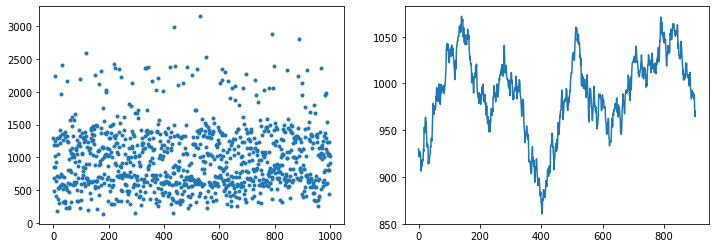

In [8]:
import matplotlib.pyplot as plt
N=100
rolling_mean=[np.mean(scores[x:x+N]) for x in range(len(scores)-N+1)]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(range(len(scores)),scores,marker='.')
plt.subplot(1,2,2)
plt.plot(rolling_mean)
plt.show()